In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import glob as glob
import os
from importlib import reload
%matplotlib inline
import sys
sys.path.append("modules")
from scipy.interpolate import interp1d

from collections import defaultdict
import pyBigWig as pw
from matplotlib_venn import venn2
import pysam
from itertools import groupby
from Bio import motifs
import logomaker
from Bio import Align
from Bio.Seq import Seq
%config InlineBackend.figure_format='retina'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
os.makedirs('../figures/Fig_yeast/', exist_ok=True)

In [3]:
import scipy.stats as stats
import pickle
with open('/home/labs/barkailab/vovam/submission_git/ads_coac_guide_binding_and_transc/data/nuc_struct.pkl', 'rb') as f:
    nucchr = pd.DataFrame(pickle.load(f))

In [4]:
gp = pd.read_csv('/home/labs/barkailab/vovam/submission_git/ads_coac_guide_binding_and_transc/data/geneinfo_params.csv', index_col=0)
aligner = Align.PairwiseAligner()


In [5]:
def align_mots(ref, seq2, aligner=aligner):
    aligned_F = aligner.align(ref, seq2)
    aligned_R = aligner.align(ref, Seq(seq2).reverse_complement())
    
    if aligned_F.score >= aligned_R.score:
        return "+"
    else:
        return "-"

def load_mot(path, mot_path):
    with open(mot_path) as handle:
        cosensus_mot = motifs.read(handle, "pfm-four-columns").consensus

        # Extract the motif sequences (not specifically used below)
    loaded_loc = pd.read_csv(os.path.join(path, 'fimo.tsv'), delimiter='\t').iloc[:-3,: ]#.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'matched_sequence']]
    seqs = loaded_loc.loc[:, 'matched_sequence']
    # loaded_loc['strand'] = seqs.apply(lambda x: align_mots(cosensus_mot, x, aligner)).values
    return loaded_loc

    
def proc_mot_in_porms(ppath, mean_data, cmotif):
    with open(cmotif) as handle:
        cosensus_mot = motifs.read(handle, "pfm-four-columns").consensus
    prom_mots = pd.read_csv(ppath, index_col=0)
    prom_mots.loc[:, 'Mid'] = np.ceil(prom_mots.Start_b + (prom_mots.End_b - prom_mots.Start_b)/2)
    seqs = prom_mots.loc[:, 'Name_b']
    # prom_mots.loc[:, 'Strand'] = seqs.apply(lambda x: align_mots(cosensus_mot, x, aligner)).values
    
    dl = dict()
    for tf in mean_data.columns:

        window = 100
        l=[]
        for i in prom_mots.iloc[:, [0,-3,-1]].to_numpy():

            sig = pd.DataFrame(mean_data.loc[:, tf]).apply(lambda x: x.loc[i[0]][int(i[2]-window) : int(i[2]+window)])
            if i[1] == '+':
                l.append(sig.T.values[0])
            else:
                l.append(sig[::-1].T.values[0])
        dl[tf] = pd.DataFrame(l, index=prom_mots.index)

    return dl
def compute_footprint_lengths(x, y, thresholds):
    """
    Compute footprint lengths for multiple percentage thresholds.
    
    Parameters:
        x (array-like): X-values (time or index)
        y (array-like): Y-values (signal intensity)
        thresholds (list): List of percentage drop values (e.g., [0.05, 0.1, 0.5])

    Returns:
        footprint_lengths (dict): Dictionary with thresholds as keys and footprint lengths as values.
    """
    # Interpolation function
    interp_func = interp1d(x, y, kind='linear')

    # Generate more dense x values for interpolation
    window = 600
    x_dense = np.linspace(min(x), max(x), window)
    y_dense = interp_func(x_dense)  # Interpolated y values

    # Find Peak
    peak_index = int(window/2)
    peak_x = x_dense[peak_index]
    peak_y = y_dense[peak_index]

    footprint_lengths = {}

    for threshold in thresholds:
        threshold_value = threshold * peak_y  # Compute threshold level

        # Find left and right drop-off points safely
        left_indices = np.where(y_dense[:peak_index] <= threshold_value)[0]
        right_indices = np.where(y_dense[peak_index:] <= threshold_value)[0]

        left_x = x_dense[left_indices[-1]] if len(left_indices) > 0 else None
        right_x = x_dense[right_indices[0] + peak_index] if len(right_indices) > 0 else None

        # Compute footprint length if both sides exist
        footprint_length = right_x - left_x if left_x is not None and right_x is not None else None

        footprint_lengths[threshold] = footprint_length

    return footprint_lengths

def find_gap_length(series, threshold):
    """
    Finds the length of the largest gap in the given series where values are below a threshold.

    Parameters:
    series (pd.Series): The mean signal data.
    threshold (float): The value below which the signal is considered absent.

    Returns:
    int: Length of the largest contiguous gap.
    """
    below_threshold = series < threshold  # Boolean mask where values are below the threshold
    gap_lengths = []  # Store lengths of gaps
    current_length = 0

    for is_below in below_threshold:
        if is_below:
            current_length += 1
        else:
            if current_length > 0:
                gap_lengths.append(current_length)
                current_length = 0

    if current_length > 0:  # Catch gap at the end
        gap_lengths.append(current_length)

    return max(gap_lengths, default=0)

def draw_arrow(ax, coords, hw, hl, wd, ya,s, text):
    start = coords[0]
    stop = coords[1]
    if (start-stop) > 0:
        ax.arrow(start, ya, -(start-stop)+hl,0, head_width=hw, head_length=hl, width=wd, fc='gainsboro', ec='black', lw=.5)
    else:
        ax.arrow(start, ya, (stop-start)-hl,0, head_width=hw, head_length=hl, width=wd, fc='gainsboro', ec='black', lw=.5)
    ax.text((min(start,stop)+np.abs(stop-start)/4), ya+10, text, size=s)

def draw_line(ax, coord, c='k', lw=.5, ls='--'):
    ax.axvline(coord, c=c, lw=lw, ls=ls)
    
def draw_promoter(chrom, start_gene,lim_data, mean_data, nucchr=nucchr,  title='', save=False, gp=gp,):
    chrom = chrom
    startchr = start_gene-4000
    stopchr = start_gene+4000
    genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)

    tracks = mean_data.loc[chrom].apply(lambda x: x[startchr:stopchr])
    fig, ax = plt.subplots(tracks.shape[0]+2,1, constrained_layout=False, sharex=True, sharey=False, dpi=150, figsize=(5,3))

    m_track = tracks.apply(lambda x: max(x))

    
    colors = ['indigo', 'maroon', 'chocolate', 'darkgreen', 'navy', 'steelblue', 'pink', 'royalblue', 'olive']
    
    maxy = []
    for tfi, axi, colori in zip(mean_data.columns, ax[1:], colors):
        plot_vec = tracks.loc[tfi]
        axi.fill_between(np.arange(plot_vec.shape[0]), plot_vec,color=colori,lw=.8)
        sns.despine(ax=axi, top=True, right=True)
        axi.set_ylabel(tfi, size=6, rotation=0, labelpad=20)
        axi.yaxis.label.set_color(colori)
        axi.set_xlim([-10,stopchr-startchr])
        # axi.set_ylim([-5, ])
        
        if m_track.loc[tfi] > lim_data[tfi]:
            axi.set_ylim([-5, m_track.loc[tfi]])
            maxy.append(m_track.loc[tfi])
        else:
            axi.set_ylim([-5, lim_data[tfi]])
            maxy.append(lim_data[tfi])
        axi.set_yticklabels(axi.get_yticklabels(), size=5)
        axi.tick_params(bottom=False, left=False)
    ax[0].set_ylim([0, 100])
    hw = 30
    hl = 50
    wd = 10
    ya = 50
    ts = 5
    for i in range(genecoords.shape[0]):
        text = genecoords.index[i]
        draw_arrow(ax[0], genecoords.values[i], hw, hl, wd, ya, ts, text)
        for axi in ax[1:]:
            draw_line(axi, genecoords.values[i][0])

    ax[0].tick_params(bottom=False, left=False)

    ax[0].set_yticklabels('')
    sns.despine(ax=ax[0], top=True, right=True, bottom=True, left=True)


    ax[-1].fill_between(range(stopchr-startchr), nucchr.loc[chrom].apply(lambda x: x[startchr:stopchr]).values[0], color='gainsboro')
    ax[-1].set_yticklabels('')
    ax[-1].set_ylabel('MNase-seq', size=6, rotation=0, labelpad=20)
    ax[-1].set_xticklabels('')
    ax[-1].tick_params(bottom=False, left=False)

    sns.despine(ax=ax[-1], top=True, right=True, bottom=False)
    fig.subplots_adjust(hspace=0.2)

    y = max(tracks.apply(lambda x: max(x))) * 0.7
    
    y = maxy[0] * 0.7
    ax[1].plot([(stopchr-startchr)-1000,(stopchr-startchr)-500],[y,y], c='k')
    ax[1].text((stopchr-startchr)-1000, y+2, '500bp', size=7)

    ax[-1].set_xlabel('Chr{} {}..{} ({}kb)'.format(chrom, startchr, stopchr, (stopchr-startchr)/1000), size=6)
    
    if save:
        fig.savefig('../figures/Fig_yeast/{}.pdf'.format(save))

In [6]:
motd = {        'GR_NR':    'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif3.motif',
            'GR_halfsite':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_dbd_fc10.bed/homerResults/motif4.motif',
        'GR_FOX':   'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif5.motif',    
        'GR_AP1':   'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif1.motif',
              'GR_KLF':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif2.motif',

    }


In [7]:
sps = glob.glob('outfiles/results/sumproms/*')

In [8]:
lsp = [pd.read_parquet(x) for x in sps]

In [9]:
fdata = pd.concat(lsp, axis=1)

In [10]:
fulllist = ['ARDBD_en_1_S13', 'ARDBD_en_2_S14', 'ARDBD_en_3_S15', 'ARDBD_en_4_S16',
       'AR_DBD_into_HO_1_S97', 'AR_DBD_into_HO_2_S98', 'AR_DBD_into_HO_3_S99',
       'AR_DBD_into_HO_4_S100', 'AR_Full_into_HO_1_S89',
       'AR_Full_into_HO_2_S90', 'AR_Full_into_HO_3_S91',
       'AR_Full_into_HO_4_S92', 'ARfull_en_2_S26', 'ARfull_en_4_S28'] + ['GR_160_240_1_S104', 'GR_160_240_3_S106', 'GR_1_60_1_S98',
       'GR_1_60_2_S99', 'GR_1_60_3_S100', 'GR_200_260_2_S108',
       'GR_200_260_3_S109', 'GR_240_300_1_S110', 'GR_240_300_2_S111',
       'GR_320_380_1_S116', 'GR_320_380_2_S117', 'GR_320_380_3_S118','GR_DBD_into_HO_1_S101',
       'GR_DBD_into_HO_2_S102', 'GR_Full_en_1_S125',
       'GR_Full_en_2_S126', 'GR_Full_en_3_S127', 'GR_IDR_1_S9', 'GR_IDR_2_S10',
       'GR_IDR_3_S11', 'GR_IDR_4_S12', 'GR_IDR_en_1_S128', 'GR_IDR_en_3_S130',
       'GR_full_1_S1', 'GR_full_2_S2', 'GR_full_3_S3', 'GR_full_4_S4'] + ['PRDBD_en_2_S22', 'PRDBD_en_3_S23', 'PR_DBD_into_HO_2_S94',
       'PR_DBD_into_HO_3_S95', 'PR_Full_into_HO_1_S85',
       'PR_Full_into_HO_2_S86', 'PRfull_en_3_S31', 'PRfull_en_4_S32']

In [11]:

complete_set_reps = fdata.loc[:, fulllist]
complete_set_reps.to_parquet('new_sumprom_reps.parquet')

complete_set_reps.columns = ['_'.join(x[:-2]) for x in complete_set_reps.columns.str.split('_')]
complete_set_reps.columns =  complete_set_reps.columns.map(lambda x: x.replace('_into_HO', '').replace('__', '_'))
# complete_set_reps.columns =  complete_set_reps.columns.map(lambda x: x.replace('_into_HO', '').replace('__', '_'))

enhancers_reps = complete_set_reps.filter(regex='en')
mean_sp = complete_set_reps.drop(enhancers_reps.columns, axis=1).T.reset_index().groupby('index').mean().T.rename_axis(None, axis=0)
complete_set = mean_sp.copy()
complete_set_reps = complete_set_reps.drop(enhancers_reps.columns, axis=1)

In [12]:
complete_set.to_parquet('new_sumprom_means.parquet')


<Axes: >

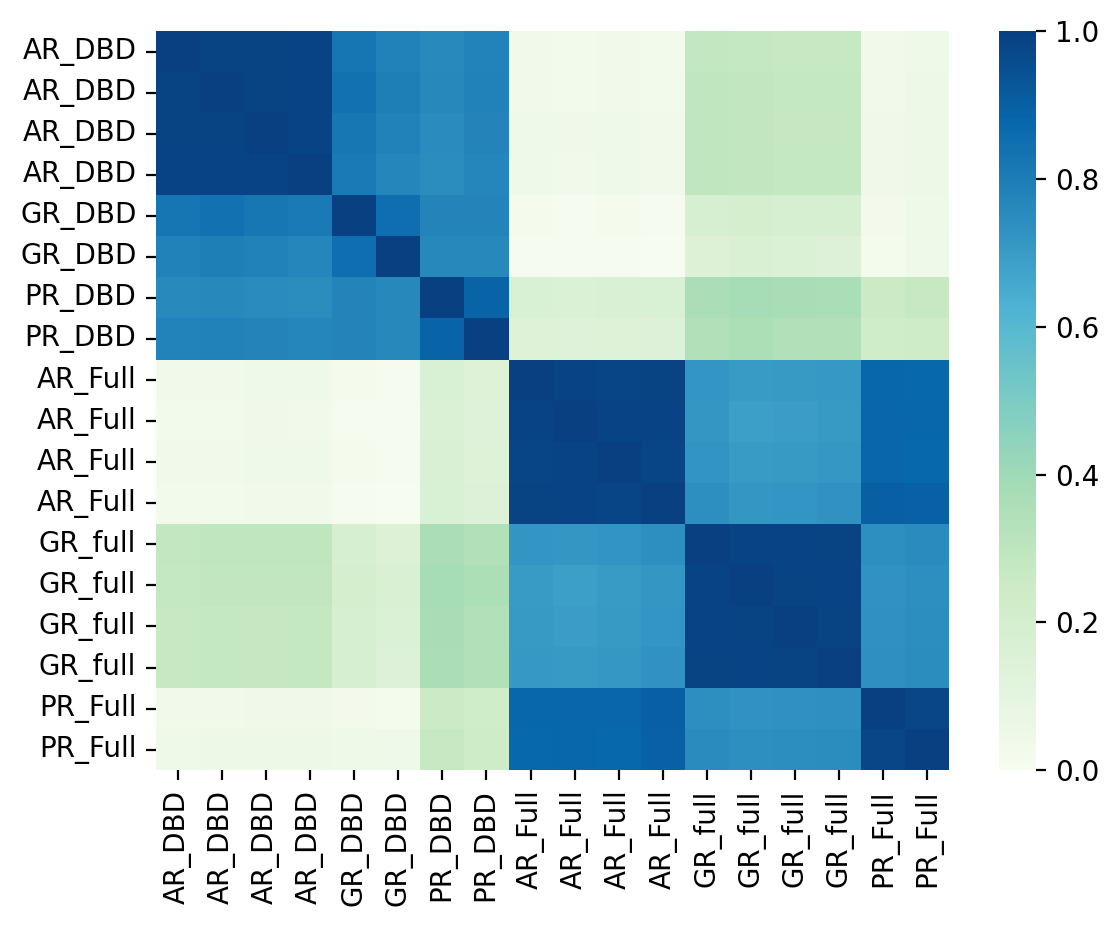

In [13]:
l = ['AR_DBD',  'GR_DBD','PR_DBD', 'AR_Full', 'GR_full',  'PR_Full']
sns.heatmap(complete_set_reps.loc[:, l].corr(), cmap='GnBu', vmin=0)

In [14]:
sumproms_all = glob.glob('/home/labs/barkailab/vovam/Mammalian/Mammal_AchInbalOvaJd/Yeast_stuff/all_tfs_yeast/outfiles/results/sumproms/*.gz')
sumproms_all_df = pd.concat([pd.read_parquet(x) for x in sumproms_all], axis=1)

In [15]:
mean_sp.columns

Index(['AR_DBD', 'AR_Full', 'GR_160_240', 'GR_1_60', 'GR_200_260',
       'GR_240_300', 'GR_320_380', 'GR_DBD', 'GR_IDR', 'GR_full', 'PR_DBD',
       'PR_Full'],
      dtype='object', name='index')

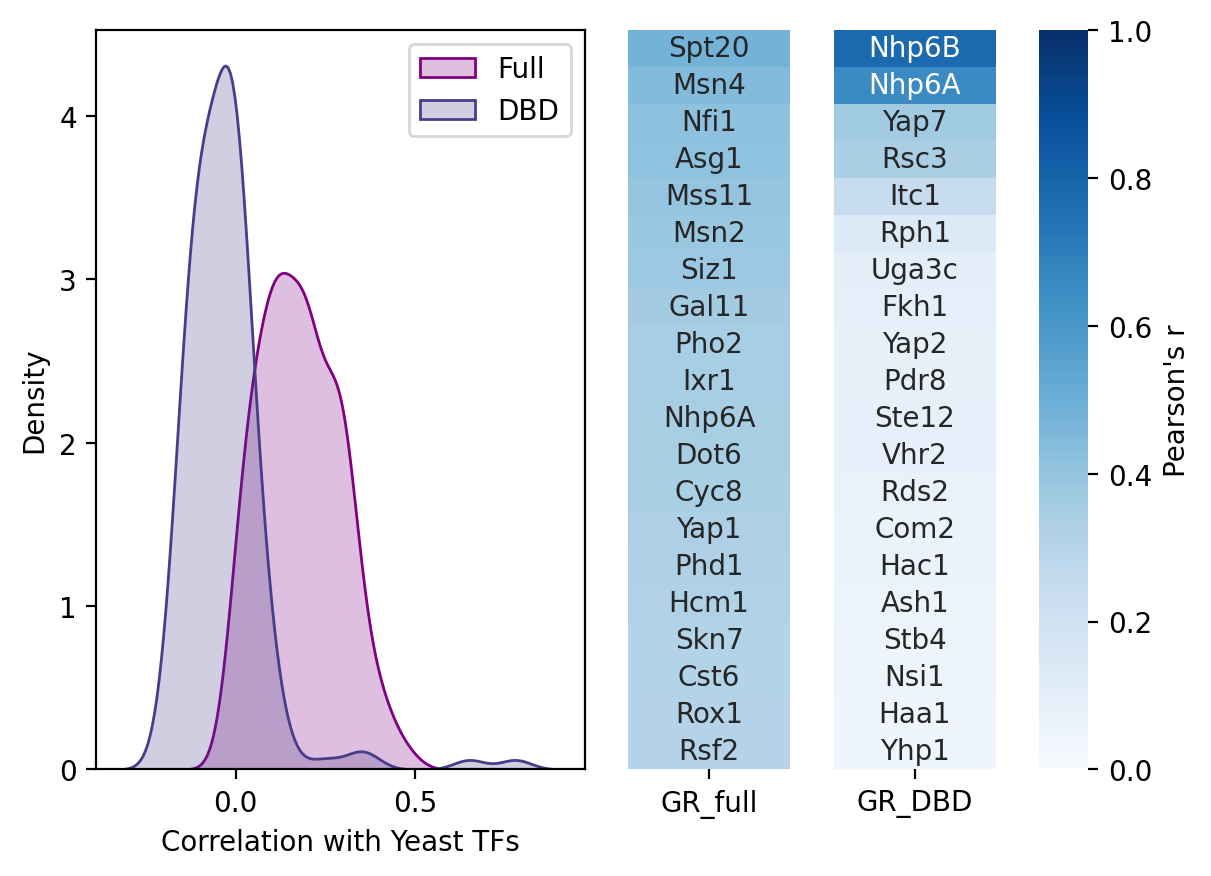

In [17]:
fig, (ax,ax1,ax2, ax3) = plt.subplots(1,4, width_ratios=[3,1,1,.3])
sns.kdeplot(pd.concat([sumproms_all_df, mean_sp.loc[:, 'GR_full']], axis=1).corr().sort_values(by='GR_full', ascending=False).loc[:, 'GR_full'].drop('GR_full'), ax=ax, common_norm=False, fill=True, color='purple', label='Full')
sns.kdeplot(pd.concat([sumproms_all_df, mean_sp.loc[:, 'GR_DBD']], axis=1).corr().sort_values(by='GR_DBD', ascending=False).loc[:, 'GR_DBD'].drop('GR_DBD'), ax=ax, common_norm=False, fill=True, color='darkslateblue', label='DBD')
ax.legend()
ax.set_xlabel('Correlation with Yeast TFs')

ftop = pd.DataFrame(pd.concat([sumproms_all_df, mean_sp.loc[:, 'GR_full']], axis=1).corr().sort_values(by='GR_full', ascending=False).loc[:, 'GR_full'].drop('GR_full').iloc[:20])
dtop = pd.DataFrame(pd.concat([sumproms_all_df, mean_sp.loc[:, 'GR_DBD']], axis=1).corr().sort_values(by='GR_DBD', ascending=False).loc[:, 'GR_DBD'].drop('GR_DBD').iloc[:20])
     
sns.heatmap(ftop, ax=ax1, yticklabels=False, cbar=False, vmin=0, vmax=1, annot=np.array(ftop.index).reshape(-1,1), fmt='', cmap='Blues')
sns.heatmap(dtop, ax=ax2, yticklabels=False, cbar_ax=ax3, vmin=0, vmax=1,annot=np.array(dtop.index).reshape(-1,1), fmt='', cmap='Blues', cbar_kws={"label":'Pearson\'s r'})

fig.savefig('../figures/Fig_yeast/topyeast.pdf')

In [18]:
norms = glob.glob('outfiles/results/norms/norm_*.gz')
outs =  glob.glob('outfiles/*.out')
norms = pd.DataFrame({x.split('norm_')[-1].split('.')[0]:x for x in norms}, index=['norms']).T
outs = pd.DataFrame({x.split('/')[-1].split('.')[0]:x for x in outs}, index=['outs']).T

In [19]:
nnorms = norms.loc[fulllist]
nnorms = nnorms.drop(nnorms.filter(regex='en', axis=0).index,)
norm_data = pd.concat([pd.read_parquet(i[0]) for i in nnorms.values], axis=1)
norm_data.columns = norm_data.columns.map(lambda x: x.split('_S')[0].replace('into_HO', '').replace('__', '_'))
mean_data = norm_data.copy()
mean_data.columns = ['_'.join(x[:-1]) for x in mean_data.columns.str.split('_')]
tracks = mean_data.T.reset_index().groupby('index').mean().T

In [22]:
full = proc_mot_in_porms('mots_in_proms_NR_full.csv', tracks,  "../" + motd['GR_NR'])
hs = proc_mot_in_porms('mots_in_proms_NR_hs.csv', tracks,  "../" + motd['GR_halfsite'])
ap = proc_mot_in_porms('mots_in_proms_AP1.csv', tracks,  "../" + motd['GR_AP1'])
fox = proc_mot_in_porms('mots_in_proms_FOX.csv', tracks,  "../" + motd['GR_FOX'])
klf = proc_mot_in_porms('mots_in_proms_KLF.csv', tracks,  "../" + motd['GR_KLF'])

In [23]:
nkeys = ['AR_DBD', 'AR_Full',  'GR_DBD', 'GR_full', 'PR_DBD', 'PR_Full']

In [24]:
truncs = ['GR_full','GR_1_60','GR_160_240',  'GR_200_260', 'GR_240_300',  'GR_320_380',
      'GR_DBD',  ]

In [ ]:
klf

In [32]:
allfoot_df = pd.DataFrame()
alldf = pd.DataFrame()

for key in truncs+['AR_DBD', 'AR_Full', 'PR_DBD', 'PR_Full']:
    
    foot_df = pd.DataFrame()
    for mot, ann, ci in zip([full, hs, ap, fox, klf], ['NR', 'NR_hs', 'AP1', 'FOX', 'KLF'], ['purple', 'salmon', 'teal', 'darkslateblue',' darkgreen']):
        
        cdata = mot[key]
        
        reg_sums = cdata.loc[:, list(np.arange(80, 96)) + list(np.arange(105,121))].sum(axis=1)

        quant = reg_sums.quantile(.9)
        threshed = cdata[reg_sums >= quant]
        top5_cols = (
                threshed
                .median()
                .sort_values(ascending=False)
                .iloc[:5]
                .index
                .astype(int)
            )
        null = threshed.iloc[:, top5_cols].values.flatten()
        func = lambda x: stats.mannwhitneyu(null, x)[1]
        calc_pvs = threshed.iloc[:, :200].apply(func, axis=0)
        calc_pvs[(calc_pvs == 0)] = calc_pvs[~(calc_pvs == 0)].min()
        m10log10pval = (-10 * np.log10(calc_pvs))
        
        alldf = pd.concat([alldf, pd.DataFrame(threshed.mean(), columns=[key+'_'+ann])], axis=1)
        foot  = pd.DataFrame(compute_footprint_lengths(m10log10pval.index.astype(int), m10log10pval, np.arange(0.05,1.05,0.05)), index=[key+'_'+ann]).T
        foot_df = pd.concat([foot_df, foot], axis=1)
    allfoot_df = pd.concat([allfoot_df, foot_df], axis=1)

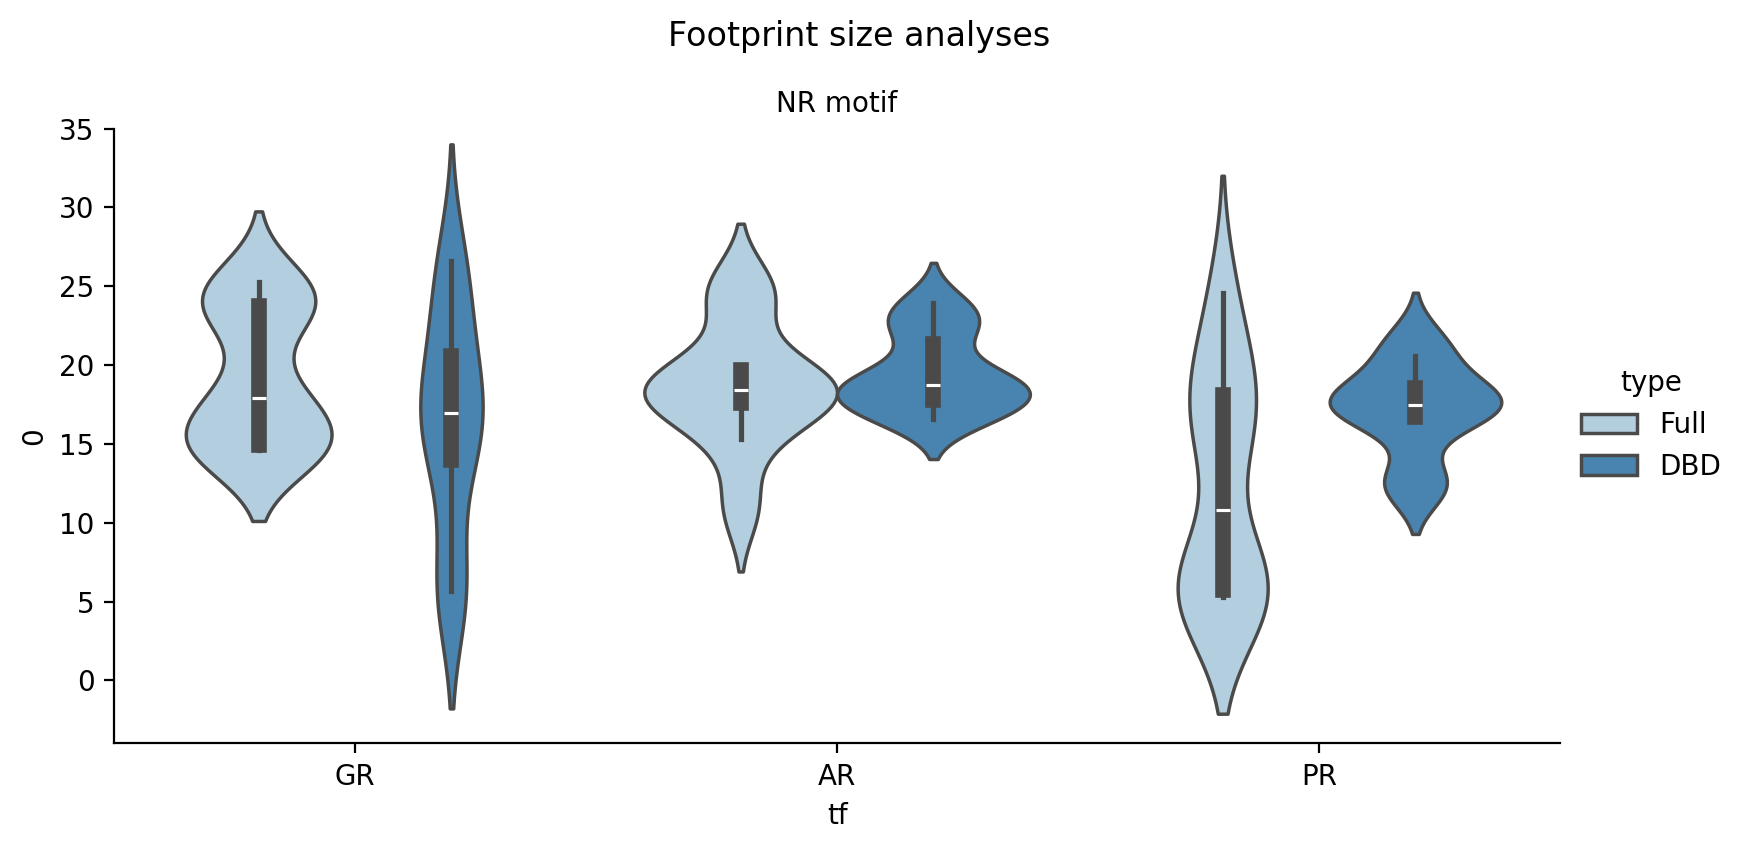

In [33]:
unstacked = allfoot_df.filter(regex='NR$').iloc[:10].unstack().reset_index()
unstacked.loc[:, 'motif'] = unstacked.level_0.apply(lambda x: x.split('_')[-1])
unstacked.loc[:, 'tf'] = unstacked.level_0.apply(lambda x: x.split('_')[0])
unstacked.loc[:, 'type'] = unstacked.level_0.apply(lambda x: x.split('_')[1])
unstacked = unstacked.drop('level_0', axis=1)
unstacked.replace('full', 'Full', inplace=True)


g = sns.catplot(
    unstacked.query("type=='Full' | type =='DBD'"), kind="violin",
    col="motif", y=0, x="tf", hue='type',
    height=4, aspect=2, sharey=True,native_scale=True, palette='Blues', bw_adjust=.8
)

g.set_titles("{col_name} {col_var}")
g.fig.suptitle("Footprint size analyses", y=1.05)  # Adjust y to control the vertical position
y_min, y_max = -4, 35  # Define your desired y-axis limits
for ax in g.axes.flat:
    ax.set_ylim(y_min, y_max)
g.figure.savefig('../figures/Fig_yeast/ar_dbd_violins.pdf')

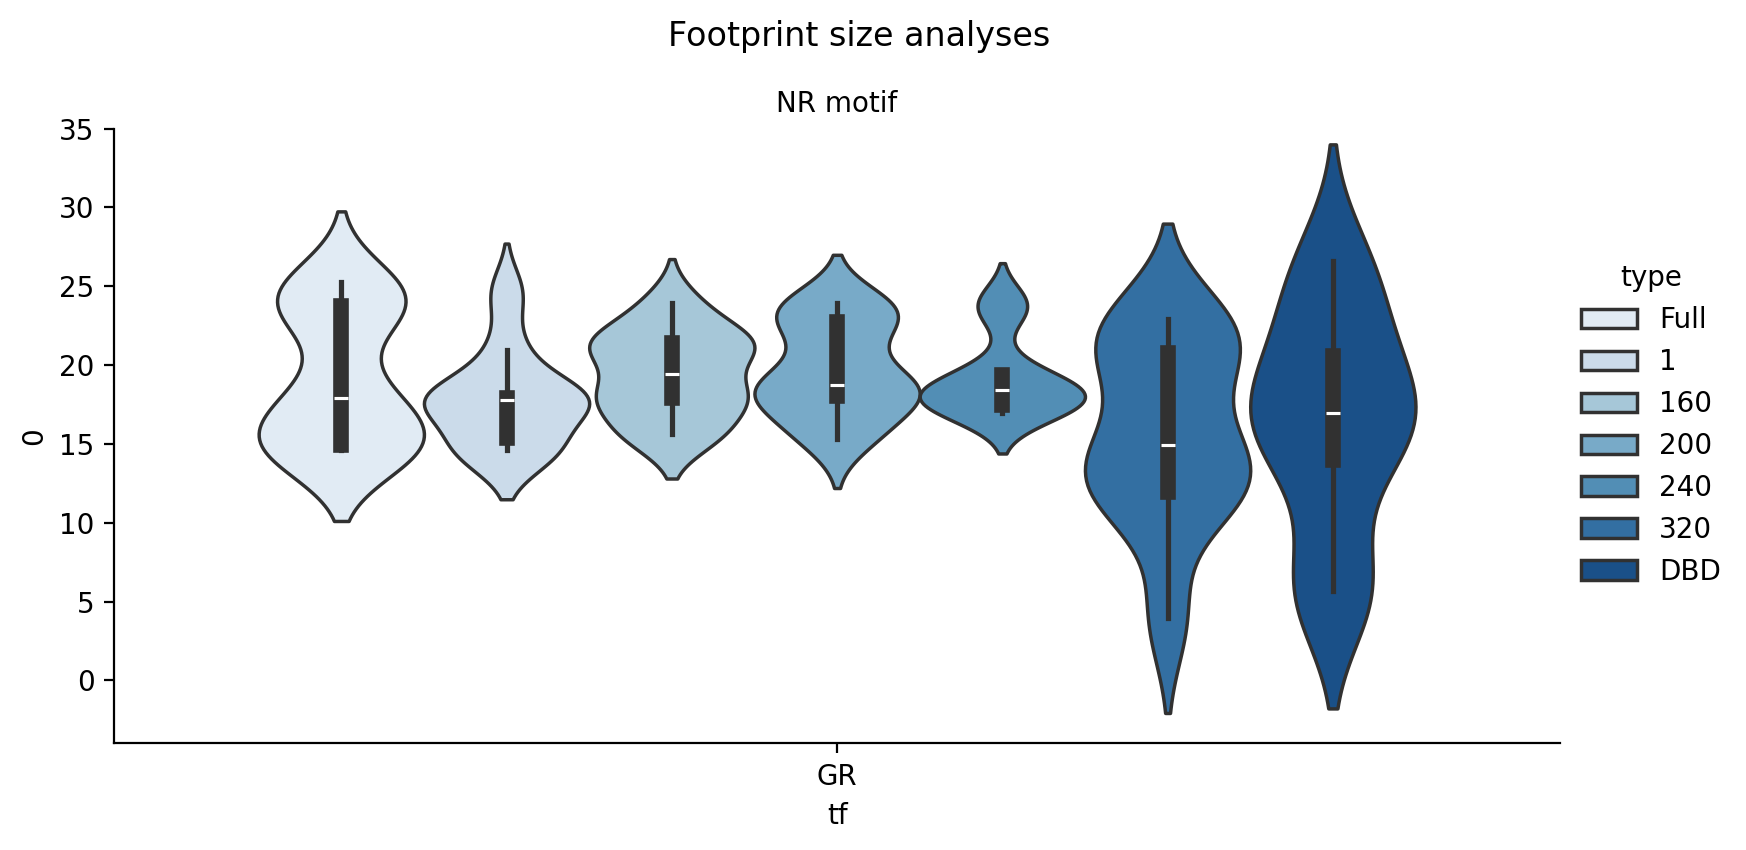

In [34]:
unstacked = allfoot_df.filter(regex='NR$').iloc[:10].unstack().reset_index()
unstacked.loc[:, 'motif'] = unstacked.level_0.apply(lambda x: x.split('_')[-1])
unstacked.loc[:, 'tf'] = unstacked.level_0.apply(lambda x: x.split('_')[0])
unstacked.loc[:, 'type'] = unstacked.level_0.apply(lambda x: x.split('_')[1])
unstacked = unstacked.drop('level_0', axis=1)
unstacked.replace('full', 'Full', inplace=True)


g = sns.catplot(
    unstacked.query("tf=='GR'"), kind="violin",
    col="motif", y=0, x="tf", hue='type',
    height=4, aspect=2, sharey=True,native_scale=True, palette='Blues', bw_adjust=.8
)

g.set_titles("{col_name} {col_var}")
g.fig.suptitle("Footprint size analyses", y=1.05)  # Adjust y to control the vertical position
y_min, y_max = -4, 35  # Define your desired y-axis limits
for ax in g.axes.flat:
    ax.set_ylim(y_min, y_max)
g.figure.savefig('../figures/Fig_yeast/truncations_violins.pdf')

In [35]:
colormap = sns.blend_palette(['white', 'slateblue'], as_cmap=True)


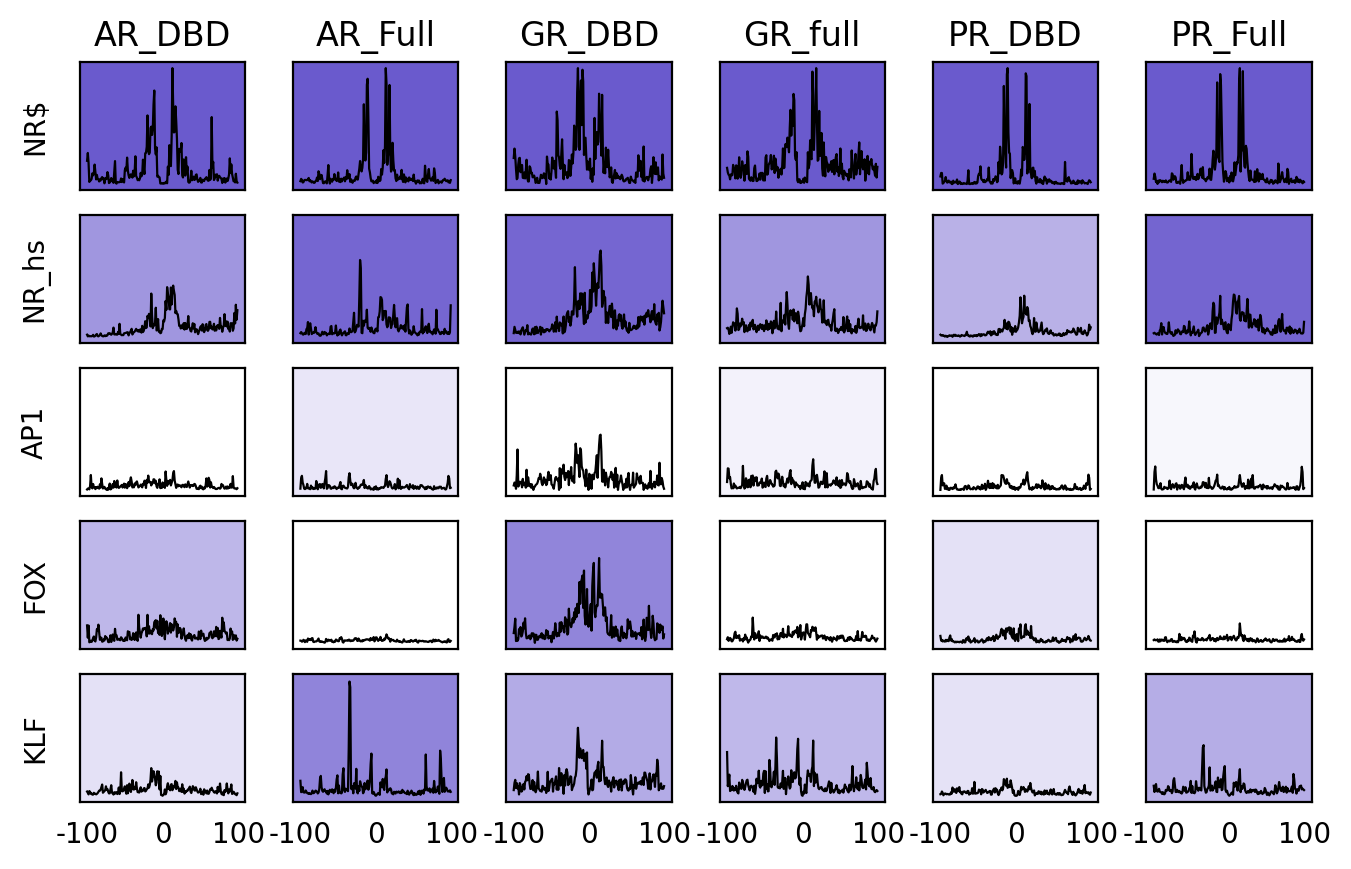

In [40]:
fig = plt.figure()
subf = fig.subfigures(1,6)
for key, subfi in zip(['AR_DBD', 'AR_Full',  'GR_DBD', 'GR_full', 'PR_DBD', 'PR_Full'], subf):
    cdat = alldf.filter(regex=key)
    maxval = cdat.mean().max()
    minval = cdat.mean().min()
    
    norm = plt.Normalize(vmin=minval, vmax=maxval)
    axes = subfi.subplots(5,1, sharey=True, sharex=True)
    axes[0].set_title(key)
    for mot, axi in zip(['NR$', 'NR_hs', 'AP1', 'FOX', 'KLF'], axes):
        # pass
        to_plot = cdat.filter(regex=mot)
        background_color = colormap(norm(to_plot.mean()))
        axi.plot(to_plot, c='k', lw=.8)
        axi.set_facecolor(background_color)
        axi.set_yticklabels('')

        axi.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

        axi.set_xticks(np.arange(0,300,100), np.arange(-100,200,100))
        if subfi == subf[0]:
            axi.set_ylabel(mot)
fig.savefig('../figures/Fig_yeast/footprint_means.pdf')

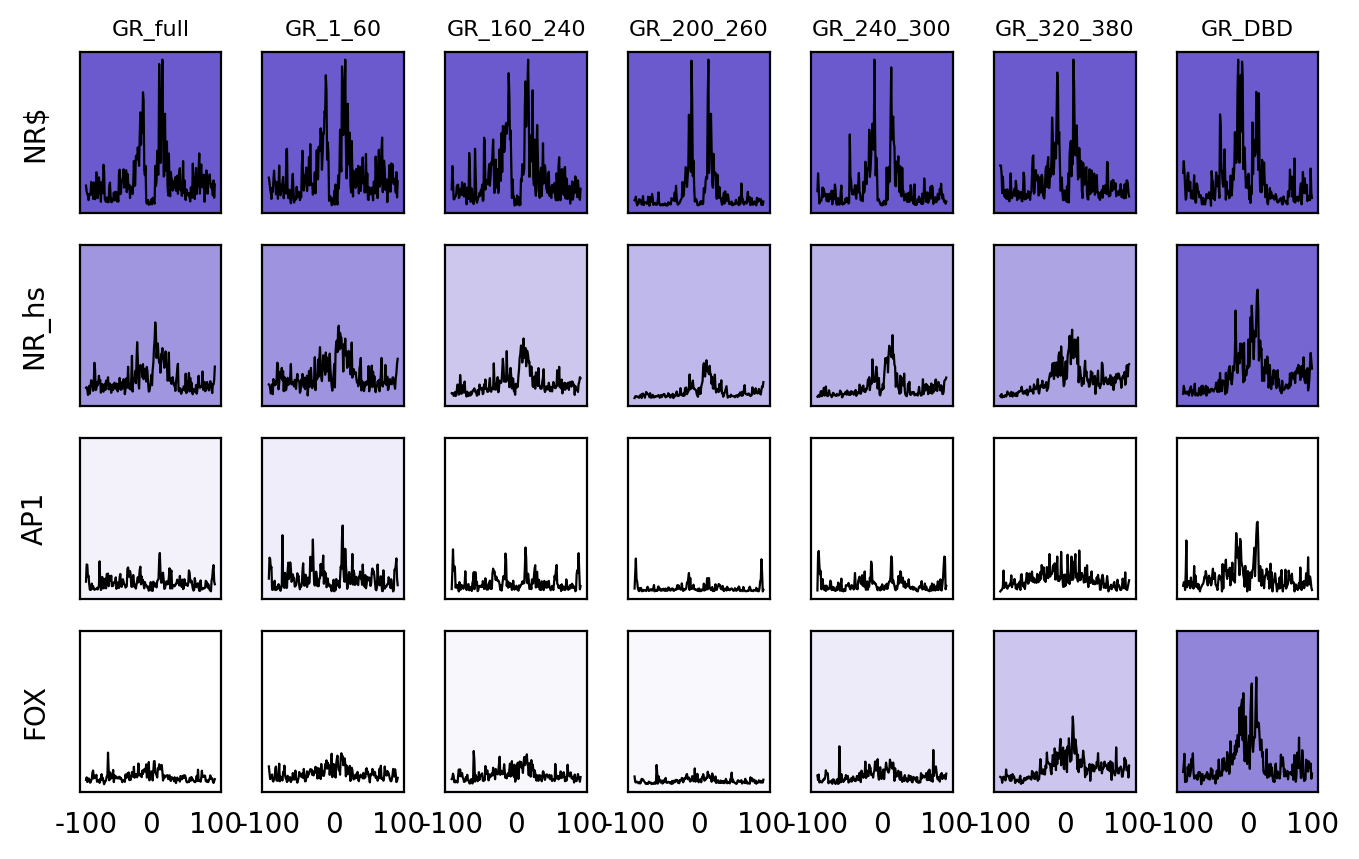

In [28]:
fig = plt.figure()
subf = fig.subfigures(1,len(truncs))
for key, subfi in zip(truncs, subf):
    cdat = alldf.filter(regex=key)
    maxval = cdat.mean().max()
    minval = cdat.mean().min()
    
    norm = plt.Normalize(vmin=minval, vmax=maxval)
    axes = subfi.subplots(4,1, sharey=True, sharex=True)
    axes[0].set_title(key, size=8)
    for mot, axi in zip(['NR$', 'NR_hs', 'AP1', 'FOX'], axes):
        # pass
        to_plot = cdat.filter(regex=mot)
        background_color = colormap(norm(to_plot.mean()))
        axi.plot(to_plot, c='k', lw=.8)
        axi.set_facecolor(background_color)
        axi.set_yticklabels('')

        axi.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

        axi.set_xticks(np.arange(0,300,100), np.arange(-100,200,100))
        if subfi == subf[0]:
            axi.set_ylabel(mot)
fig.savefig('../figures/Fig_yeast/trunc_footprint_means.pdf')

In [61]:
df_for_sp = pd.read_csv('/home/labs/barkailab/vovam/pipelines/jingdef.csv', index_col=0)


In [62]:
df_for_sp = df_for_sp.set_index('name')

/tmp/ipykernel_24687/421000017.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tracks_maxes = tracks.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
/tmp/ipykernel_24687/2575027503.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_tickla

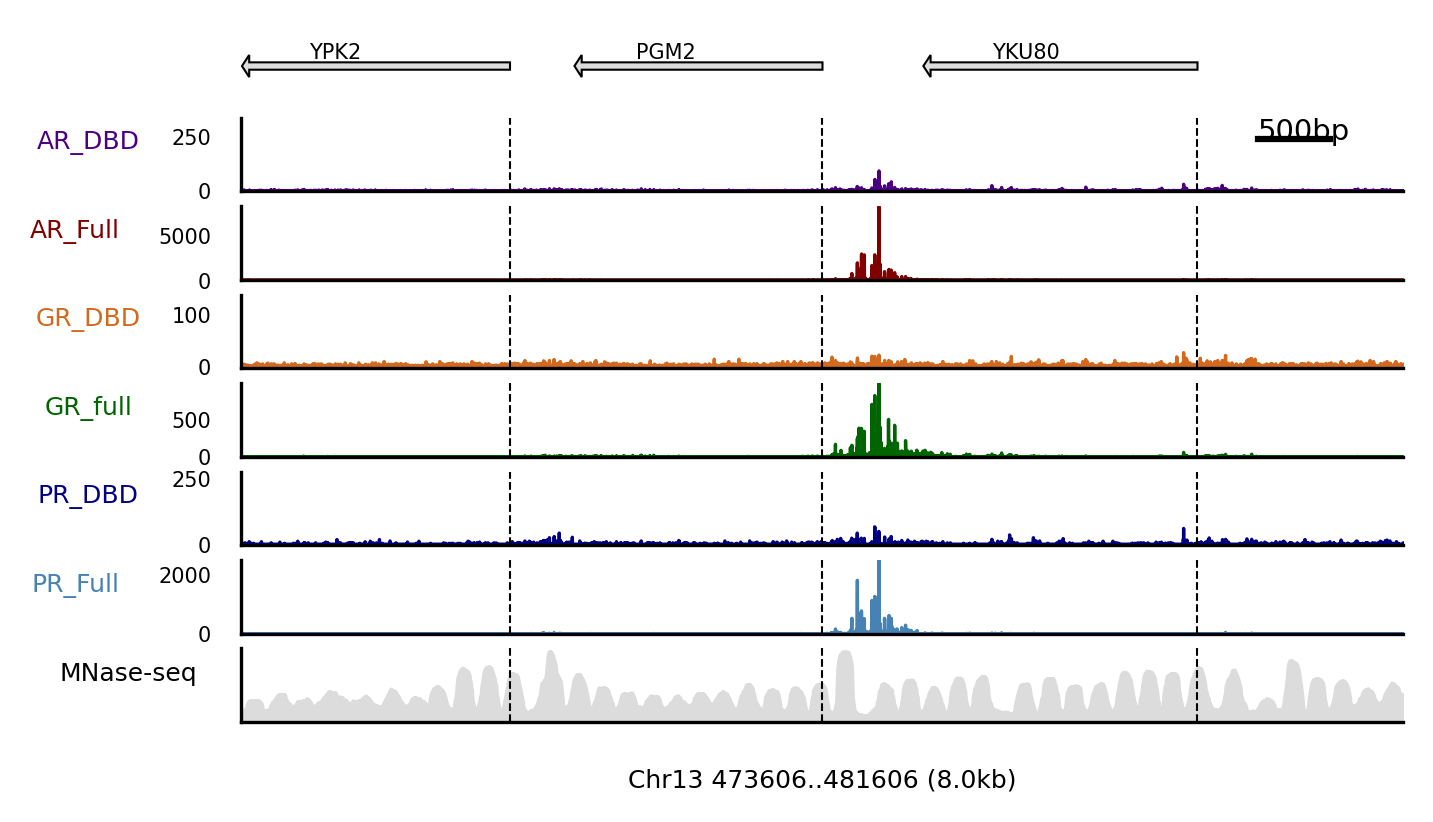

In [63]:

tracks_maxes = tracks.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
a,b = df_for_sp.loc['PGM2', ['Chromosome', 'TSS']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=tracks.filter(regex='DBD|Full|full'),  title='', save='PGM2', gp=gp,)

/tmp/ipykernel_24687/2575027503.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158:

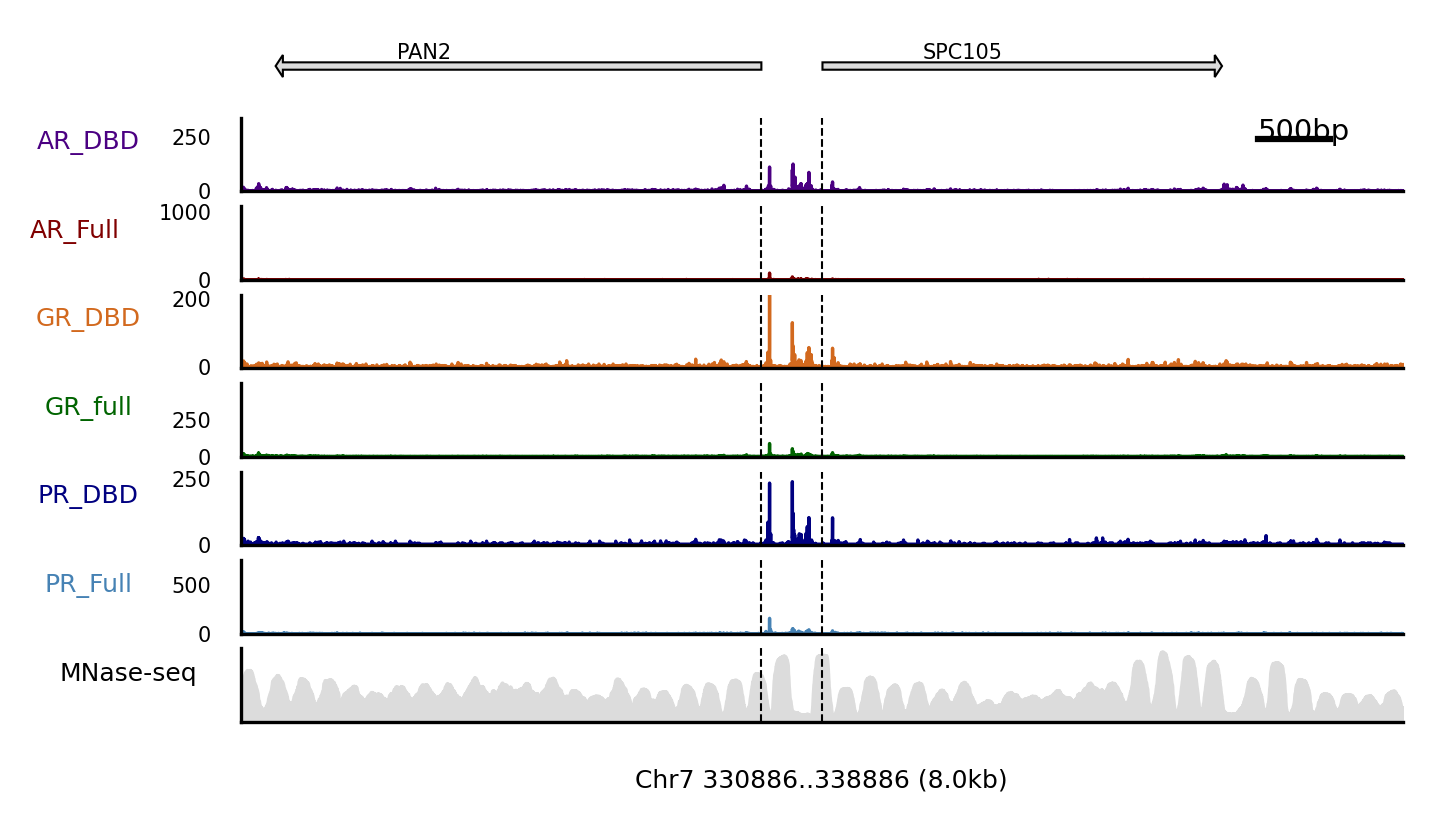

In [64]:

a,b = df_for_sp.loc['SPC105', ['Chromosome', 'TSS']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=tracks.filter(regex='DBD|Full|full'),  title='', save='SPC105', gp=gp,)

/tmp/ipykernel_24687/2575027503.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158:

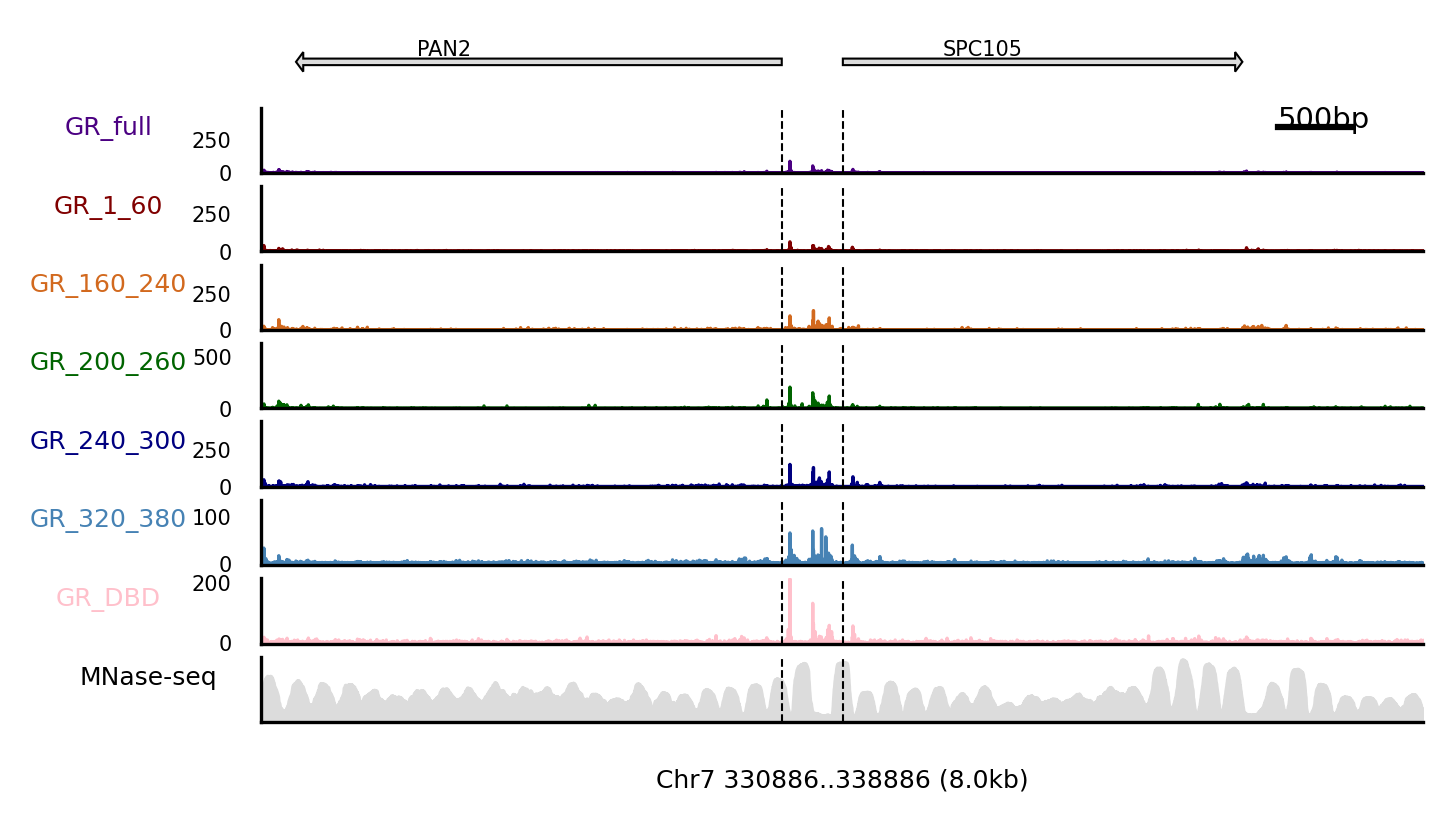

In [69]:

a,b = df_for_sp.loc['SPC105', ['Chromosome', 'TSS']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=tracks.loc[:, truncs],  title='SPC105_truncations', save='SPC105_truncations', gp=gp,)

/tmp/ipykernel_24687/2575027503.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_24687/2575027503.py:158:

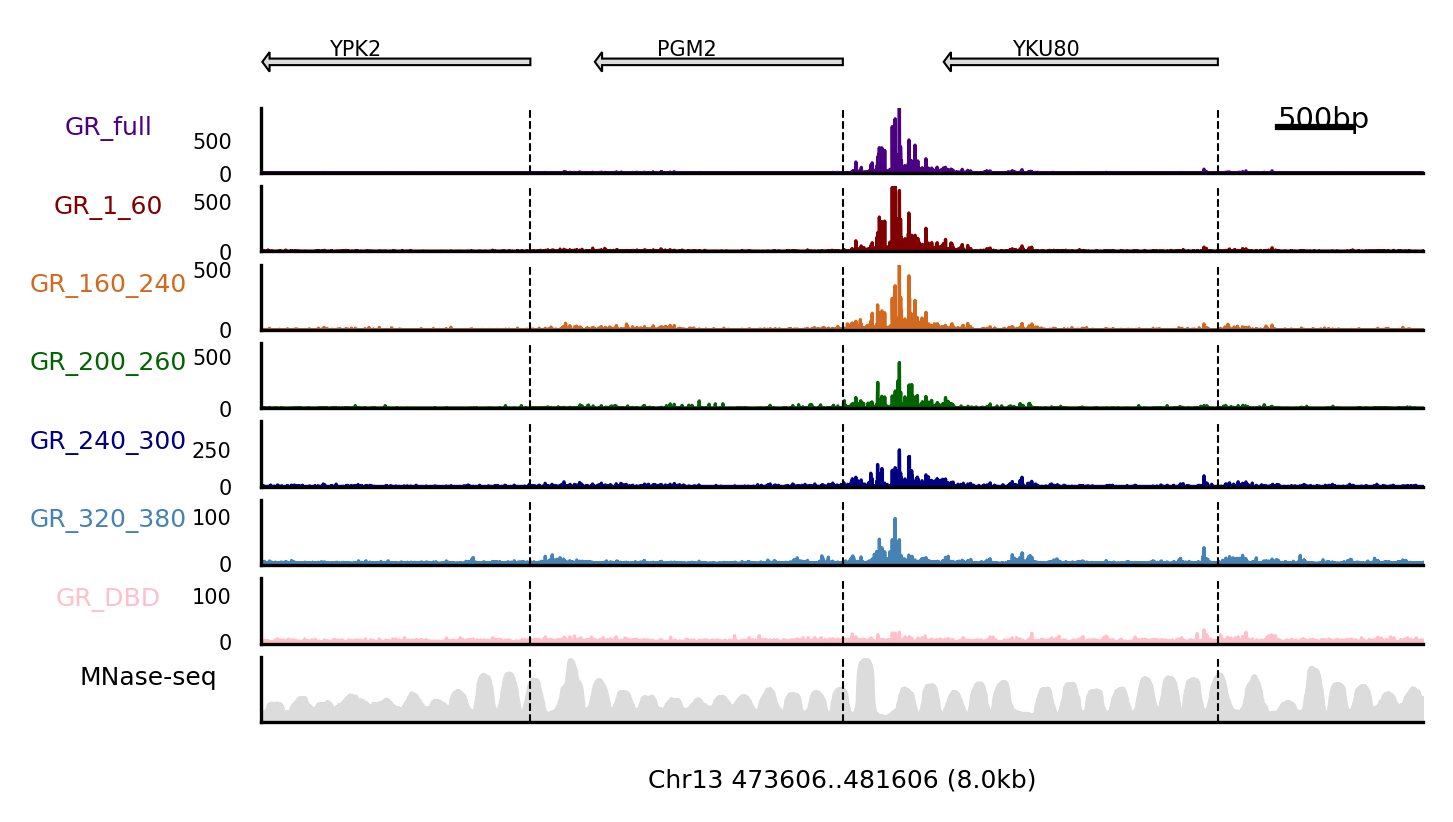

In [68]:

a,b = df_for_sp.loc['PGM2', ['Chromosome', 'TSS']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=tracks.loc[:, truncs],  title='PGM2_truncations', save='PGM2_truncations', gp=gp,)

/tmp/ipykernel_3267796/2274221580.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dpn_pref = pd.DataFrame({0:dts}).applymap(lambda x: opn_vec.loc[x].values)
/tmp/ipykernel_3267796/2274221580.py:9: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(pd.DataFrame({x:pd.Series(k) for x,k in dpn_pref.to_dict()[0].items()}), ax=ax, palette=sns.color_palette('GnBu', n_colors=2), showfliers=False,)


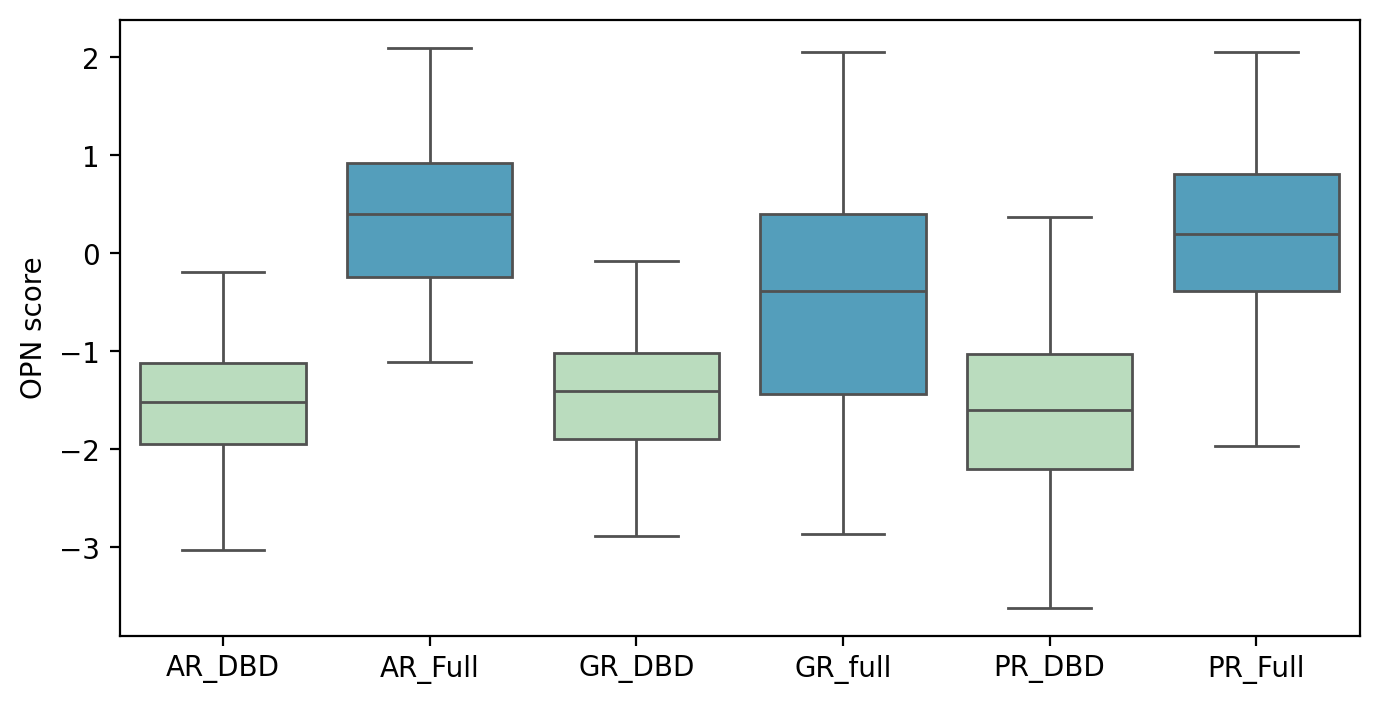

In [81]:
opn_vec = pd.read_csv('/home/labs/barkailab/vovam/pipelines/comp_gp.csv', index_col=0).set_index('name').iloc[:, -1]
zscored = ((mean_sp - mean_sp.mean()) / mean_sp.std()).filter(regex='DBD|Full|full')
dts = dict()
for tf in zscored.columns:
    dts[tf] = list(zscored.query("{}>=3".format(tf)).index)
    
dpn_pref = pd.DataFrame({0:dts}).applymap(lambda x: opn_vec.loc[x].values)
fig, ax = plt.subplots(1, figsize=(8,4))
sns.boxplot(pd.DataFrame({x:pd.Series(k) for x,k in dpn_pref.to_dict()[0].items()}), ax=ax, palette=sns.color_palette('GnBu', n_colors=2), showfliers=False,)
# sns.swarmplot(pd.DataFrame({x:pd.Series(k) for x,k in dpn_pref.to_dict()[0].items()}), ax=ax, palette=['gainsboro'], edgecolor='k', linewidth=.5)
ax.set_ylabel('OPN score')
fig.savefig('../figures/Fig_yeast/opn.pdf')

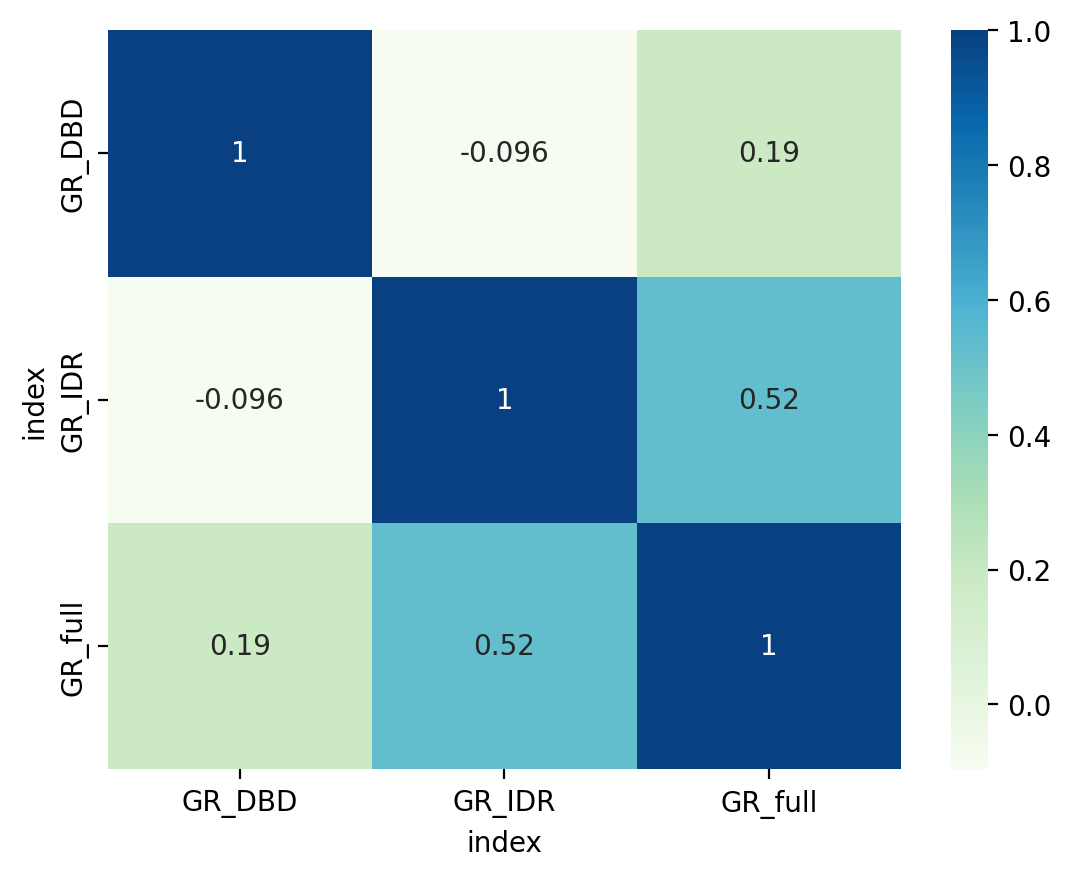

In [37]:
fig, ax = plt.subplots(1)
sns.heatmap(mean_sp.loc[:, 'GR_DBD,GR_IDR,GR_full'.split(',')].corr(), cmap='GnBu', ax=ax, annot=True)
fig.savefig('../figures/Fig_yeast/gr_idr_dbd.pdf')

In [179]:
prom_data = glob.glob('outfiles/results/prom_signals/*signals.gz')

prom_data = pd.DataFrame({x.split('/')[-1].split('_sig')[0]:x for x in prom_data}, index=['prompath']).T
prom_data = prom_data.loc[fulllist]

prom_data.columns = prom_data.columns.map(lambda x: x.split('_S')[0].replace('into_HO', '').replace('__', '_'))
enhancers_prom = prom_data.filter(regex='en', axis=0)
regp_data = prom_data.drop(enhancers_prom.index)

regp_data.index = ['_'.join(x.split('_')[:-2]) for x in regp_data.index]
repeats = regp_data.reset_index().groupby('index').agg(lambda x: list(x)).squeeze().to_dict()


In [180]:
pd.read_parquet(df)

,0,1,2,3,4,5,6,7,8,9,...,840,841,842,843,844,845,846,847,848,849
name,,,,,,,,,,,,,,,,,,,,,
TFC3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.152201,0.000000,2.304403,2.304403,3.456604,1.152201,0.000000
VPS8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EFB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,4.608806,1.152201,0.000000,0.000000,1.152201,0.000000,4.608806
YAL004W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SSA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.152201,1.152201,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YIR020C-B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YIR021W-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YIR023C-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
big_d = {}
for key, items in repeats.items():
    dfl = []
    for df in items:
        dfl.append(pd.read_parquet(df).loc[mean_sp.index].values)
    big_d[key] = pd.DataFrame(np.nansum(dfl, axis=0)/len(dfl), index=mean_sp.index)

In [182]:
genes = pd.read_csv('/home/labs/barkailab/vovam/pipelines/new_prom_def_seqs.csv', index_col=0)

In [337]:
def filter_elements_by_distance(arr, min_distance=50):
 

    # Initialize the filtered list with the first element
    filtered_arr = [arr[0]]

    for i in range(1, len(arr)):
        # Calculate the distance between the current element and the last added element
        distance = arr[i] - arr[i - 1]

        # Check if the distance is greater than the minimum distance
        if distance >= min_distance:
            filtered_arr.append(arr[i])

    return filtered_arr

def proc_row(row, name, geneseq, window=40):
    # row = row.dropna().rolling(window=window, center=True).mean()
    row = row.dropna().values#.rolling(window=window, center=True).mean()

    lim = row.max() * 0.5
    indices = np.where(row>=lim)[0]
    dna_dat = geneseq.loc[name]
    if indices.shape[0] > 0:
        indices = filter_elements_by_distance(indices, 40)
    else:
        return None
    
    if dna_dat.strand == 'positive':
        seq = dna_dat.seq
    else:
        seq = dna_dat.rseq
    pd = dict()
    sd = dict()
    for i, ind in enumerate(indices):
        peak =seq[ind-window:ind+window]
        signal = row[ind-window:ind+window].sum()
        if peak != '':
            pd[name+'_'+str(i)] = peak
            sd[name+'_'+str(i)] = signal
    if pd:
        return (pd, sd)

In [313]:
prom_nans = pd.read_pickle('../../KLF_project/Klf4_all_700bp_signals.gz').isna()

for i in big_d.keys():
    
    trial = big_d[i].iloc[:, :-150]
    trial[prom_nans] = np.nan
    t_ind = trial.mean(axis=1).sort_values(ascending=False).index[:200]
    peak_call = trial.loc[t_ind].apply(lambda x: proc_row(x, x.name, genes), axis=1)
    allp_seqs_d = dict()
    res1 = [x[0] for x in peak_call.values if x]
    for x in res1:
        if x:
            allp_seqs_d.update(x)

    allp_sigs_d = dict()
    res2 = [x[1] for x in peak_call.values if x]
    for x in res2:
        allp_sigs_d.update(x)

    peaks = pd.DataFrame(allp_sigs_d, index=['peaks']).T
    sequences = pd.DataFrame({key:pd.Series(val) for key, val in allp_seqs_d.items()}).T
    if i == 'GR_DBD_into_HO':

        fin_d = sequences.loc[:,:].squeeze().to_dict()
#     fin_d = sequences.loc[peaks[(peaks > peaks.quantile(.9)).values].index].squeeze().to_dict()
    fin_d = sequences.loc[peaks.sort_values(by='peaks', ascending=False).index[:100]].squeeze().to_dict()
    peaksite = ''

    for peakn,  peaksi in fin_d.items():
        peaksite += f'>{peakn}\n{peaksi}\n'

    with open(f'peaks/{i}_peaks.fa', 'w') as f:
        f.write(peaksite)

/tmp/ipykernel_3620752/864584662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial[prom_nans] = np.nan
/tmp/ipykernel_3620752/864584662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial[prom_nans] = np.nan
/tmp/ipykernel_3620752/864584662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial[prom_nans] =

In [122]:
verteb_peaks = glob.glob('peaks/*yeast_res')

In [123]:
nind = ['AR-halfsite(NR)/LNCaP-AR-ChIP-Seq(GSE27824)/Homer',
       'MRE(NR)/Neuro2A-NR3C2-ChIPnexus(GSE115417)/Homer',
       'PR(NR)/T47D-PR-ChIP-Seq(GSE31130)/Homer',
       'GRE(NR),IR3/RAW264.7-GRE-ChIP-Seq(Unpublished)/Homer',
       'PGR(NR)/EndoStromal-PGR-ChIP-Seq(GSE69539)/Homer',
       'ARE(NR)/LNCAP-AR-ChIP-Seq(GSE27824)/Homer',
       'GRE(NR),IR3/A549-GR-ChIP-Seq(GSE32465)/Homer']

In [124]:
# l = []
# for i in verteb_peaks:
#     l.append(pd.read_csv(f'{i}/knownResults.txt', delimiter='\t').set_index('Motif Name').loc[nind].loc[:, 'P-value']<1)
l = []
for i in verteb_peaks:
    l.append(pd.read_csv(f'{i}/knownResults.txt', delimiter='\t').set_index('Motif Name').loc[:, 'P-value']<1)

In [125]:
enrich = pd.concat(l, axis=1)
enrich.columns = verteb_peaks
enrich = enrich[~(enrich.sum(axis=1) == 0)]
fig, ax = plt.subplots(1)
sns.heatmap(enrich.filter(regex='ull|DBD').sort_index(axis=1),
            cbar=False,
            cmap=sns.blend_palette(['white', 'cornflowerblue'], n_colors=2),
            linecolor='k', linewidth=1, ax=ax)
fig.savefig('../figures/Fig_yeast/mot_enrich_yeast.pdf')

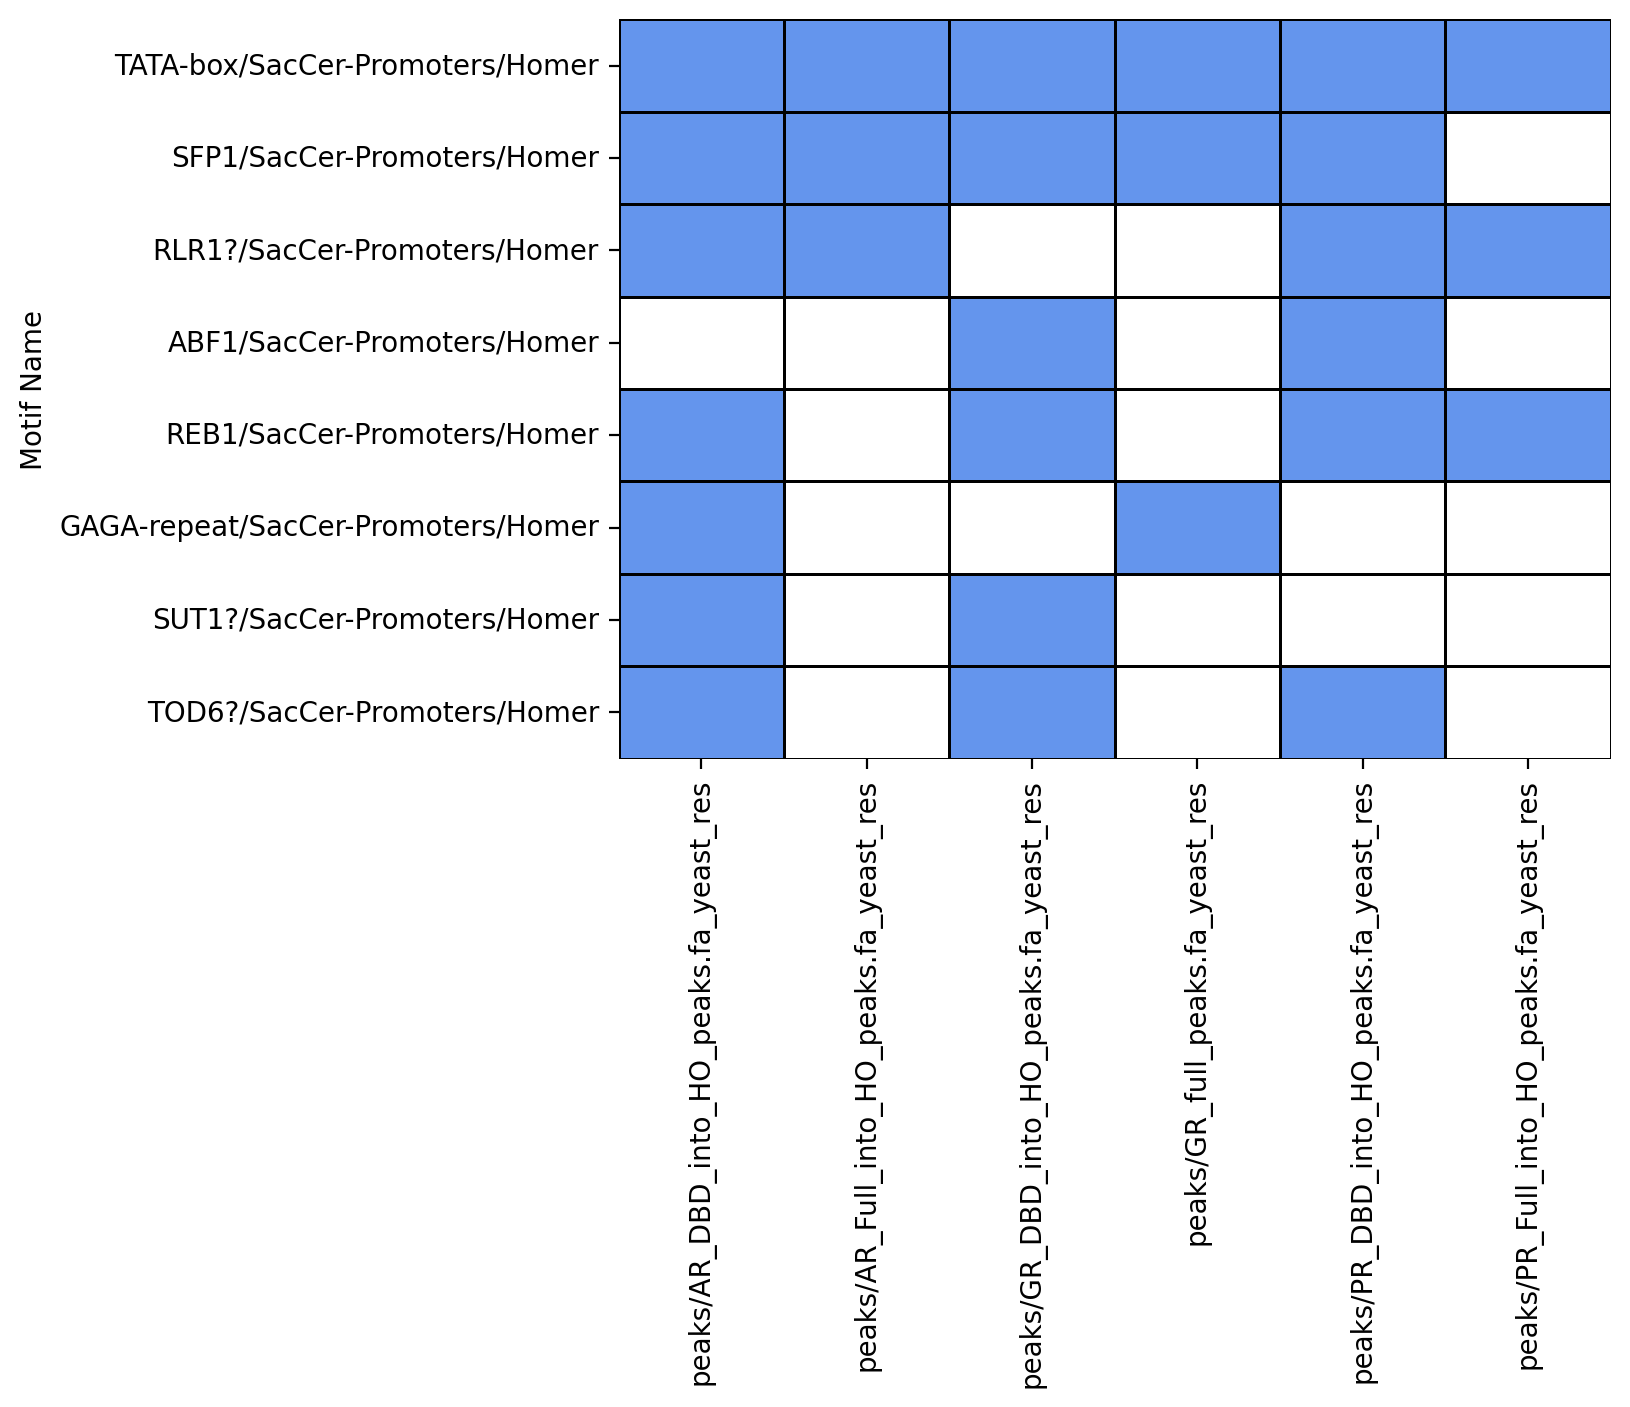

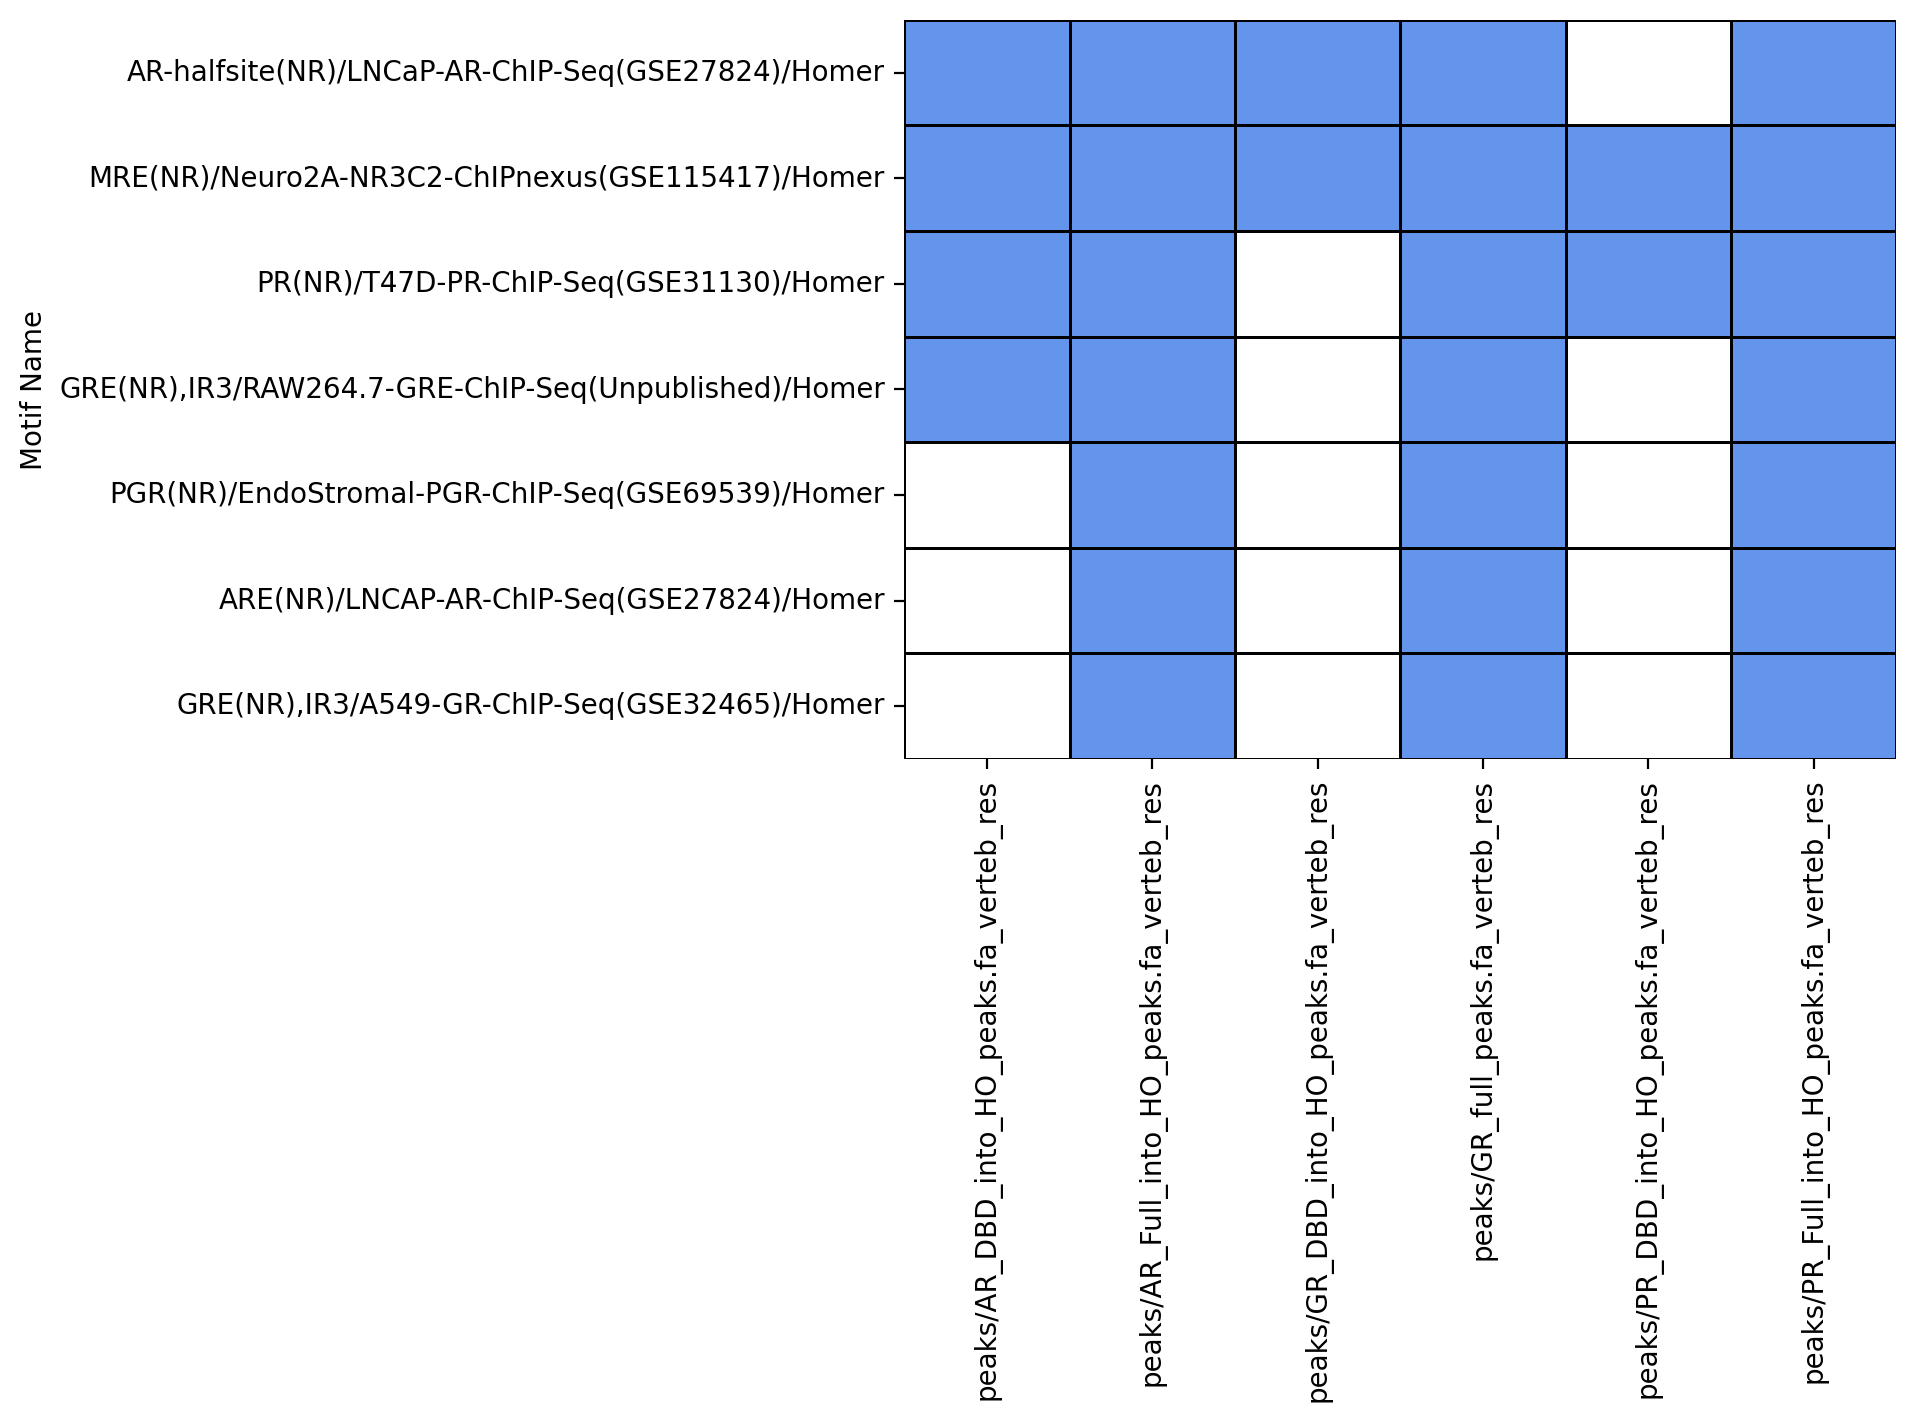

In [130]:
verteb_peaks = glob.glob('peaks/*verteb_res')
l = []
for i in verteb_peaks:
    l.append(pd.read_csv(f'{i}/knownResults.txt', delimiter='\t').set_index('Motif Name').loc[nind].loc[:, 'P-value']<1)
enrich = pd.concat(l, axis=1)
enrich.columns = verteb_peaks
enrich = enrich[~(enrich.sum(axis=1) == 0)]
fig, ax = plt.subplots(1)
sns.heatmap(enrich.filter(regex='ull|DBD').sort_index(axis=1),
            cbar=False,
            cmap=sns.blend_palette(['white', 'cornflowerblue'], n_colors=2),
            linecolor='k', linewidth=1, ax=ax)
fig.savefig('../figures/Fig_yeast/mot_enrich_verteb.pdf')